In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
'''
LightGBM module

the module can be use for both classification and regression problem the appropriate objective method should be defined.
more information can be find here
https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst
http://lightgbm.readthedocs.io/en/latest/Python-API.html

AT THE MOMENT
User can NOT define a customized objective function and evaluation function

optimization with grid search is easy first make a grid

make_grid(learning_rate = [1, 2, 3], max_depth = [3, 4, 5])

then run the optimization
optimization(self, X, y, X_test, y_test, verbose_eval = False, num_boost_round = None, early_stopping = 2)

to see the result and select best parameters
scores()


get the importance features and plot them is another awesome part of this module :)

get_importance()
plot_importance()

comparision of XGB and LGB
https://sites.google.com/view/lauraepp/parameters

used skopt module for bayesian optimization

'''
import catboost as cb
import pandas as pd
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from io import StringIO
import sys
from tqdm import tqdm

color = sns.color_palette()

class CLF(object):
    def __init__(self, num_boost_round=10, objective=None, metric='None', feval=None, fobj=None, **kwargs):
        self.clf = None
        self.grid_params = None
        self.result = None
        self.grid_list = []
        self.feval = feval
        self.fobj = fobj
        self.num_boost_round = num_boost_round
        self.params = kwargs
        if not fobj:
            if objective:
                print("Built a CatBoost with defiend objective function")
                self.objective = objective
                self.metric = metric
#                self.clf = cb.CatBoostClassifier(objective = objective, eval_metric = metric, **self.params)
            else:
                print("Built a Catboost with default objective")
                self.objective = 'Logloss'
                self.eval_metric = 'AUC'
#                self.clf = cb.CatBoostClassifier(objective = 'Logloss', eval_metric = 'AUC', **self.params)
            
        print(self.params)
        
    def set_params(self, print_out=True, **params):
        if 'num_boost_round' in params:
            self.num_boost_round = params.pop('num_boost_round')
        self.params.update(params)
        if print_out:
            print(self.params)
            
    def set_params_scores(self, dt, N=1):
        print(self.params)
        params = dt.iloc[N].to_dict()
        if 'score' in params:
            del params['score']
        if 'iterations' in params:
            self.num_boost_round = params.pop('iterations')
        self.params.update(params)
        print(self.params)
        
    def set_params_dic(self, dic):
        if 'num_boost_round' in dic:
            self.num_boost_round = dic.pop('num_boost_round')
        self.params.update(dic)
        print(self.params)
        
    def fit(self, X, y, num_boost_round=None, categorical=None, verbose=False):
        num_boost_round = num_boost_round or self.num_boost_round
        self.clf = cb.CatBoostRegressor(objective = self.objective, eval_metric = self.metric, 
                                         iterations=num_boost_round, **self.params)
        self.clf.fit(X=X, y=y, cat_features=categorical, verbose_eval=verbose)
        
    def predict(self, X):
        return self.clf.predict(X)
    
    def predict_proba(self, X):
        return self.clf.predict_proba(X)
    
    def get_params(self, deep=True):
        return self.params

    def get_importance(self):
        importance = {}
        for key, val in zip(self.clf.feature_name(), self.clf.feature_importance()):
            importance[key] = val
        return importance

    def plot_importance(self, N = 10):
        importance = {}
        for key, val in zip(self.clf.feature_name(), self.clf.feature_importance()):
            importance[key] = val

        import operator
        importance = sorted(importance.items(), key=operator.itemgetter(1))

        importance_df = pd.DataFrame(importance, columns=['feature', 'fscore'])
        importance_df['fscore'] = importance_df['fscore'] / importance_df['fscore'].sum()

        plt.figure()
        importance_df[-N:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 5))
        plt.title('XGBoost Feature Importance')
        plt.xlabel('relative importance')
        plt.ylabel('')
        plt.show()
    
    def fit_eval(self, X, y, X_test, y_test, num_boost_round = None, early_stopping = 5,
                 categorical=None, train_score=False, Min=True, print_out=False):
        num_boost_round = num_boost_round or self.num_boost_round
        
        self.clf = cb.CatBoostRegressor(objective = self.objective, eval_metric = self.metric, 
                                    iterations=num_boost_round, od_type='Iter', od_wait=early_stopping, **self.params)

        
        if self.feval == None:
            old_stdout = sys.stdout
            result = StringIO()
            sys.stdout = result
            
            self.clf.fit(X=X, y=y, eval_set=(X_test, y_test), use_best_model=True,
                     cat_features=categorical, verbose_eval=50)
            
            sys.stdout = old_stdout
            result_string = result.getvalue()
        else:
            print(" Later :)")
#             self.params.update({'metric': 'None'})
#             self.clf = lgb.train(params = self.params, train_set = dtrain, num_boost_round = num_boost_round,
#                              valid_sets = [dtrain, dtest], valid_names = ['train', 'valid'],
#                              verbose_eval = verbose_eval,
# #                             feval = self.evalerror, 
#                              early_stopping_rounds = early_stopping)
        
        nstr = result_string.find("bestTest")
        score = float(result_string[nstr+11:nstr+20])

        if print_out:
#            print("Number of iteration: ", self.clf.tree_count_, " Score: ", score)
            return {"iteration":self.clf.tree_count_, "score":score} 
        else:
            if Min:
                return score
            else:
                return -score
        
    def fit_cv(self, X, y, cv, verbose_eval = False, num_boost_round = None, early_stopping = 5,
                 categorical=None, print_out=False, Min=True):
        
        num_boost_round = num_boost_round or self.num_boost_round
        
        self.clf = cb.CatBoostRegressor(objective = self.objective, eval_metric = self.metric, 
                                    iterations=num_boost_round, od_type='Iter', od_wait=early_stopping, **self.params)
        scores = []
        
        for i, (train_index, test_index) in enumerate(cv.split(X, y)):

            if self.feval == None:
                old_stdout = sys.stdout
                result = StringIO()
                sys.stdout = result
                
                self.clf.fit(X=X[train_index], y=y[train_index], eval_set=(X[test_index], y[test_index])
                             , use_best_model=True, cat_features=categorical, verbose_eval=50)
                
                sys.stdout = old_stdout
                result_string = result.getvalue()
            else:
                print(" Later :)")
#                 self.params.update({'metric': 'None'})
#                 self.clf = lgb.train(params = self.params, train_set = dtrain, num_boost_round = num_boost_round,
#                              valid_sets = [dtrain, dtest], valid_names = ['train', 'valid'],
#                              verbose_eval = verbose_eval,
# #                             feval = self.evalerror, 
#                              early_stopping_rounds = early_stopping)
            
            nstr = result_string.find("bestTest")
            score = float(result_string[nstr+11:nstr+20])
            scores.append(score)
            
            if print_out:
                print("Kfold: ", i, "Number of iteration: ", self.clf.tree_count_, " Score: ", score)
#                return {"Kfold: ": i,"iteration":self.clf.tree_count_, "score":score}

        if not print_out:
            if Min:
                return np.mean(scores)
            else:
                return -np.mean(scores)

        
    def grid(self, keys, comb, it=0):
        if len(keys) == it:
            return

        for x in self.grid_params[keys[it]]:
            comb.append(x)
            self.grid(keys, comb, it+1)
            if len(comb) == len(keys):
                self.grid_list.append(comb[:])
            comb.pop()
    
    def make_grid(self, **kwargs):
        self.grid_list = []
        self.grid_params = kwargs
        print(self.params)
        print(self.grid_params)
        self.grid(list(self.grid_params.keys()), [])
        print("Number of iteration for Optimization: ", len(self.grid_list))
        
    def optimization(self, X, y, X_test, y_test, verbose_eval = False, num_boost_round = None, early_stopping = 2,
                     categorical=None):
        
        if categorical:
            print("Used categorical features: ", categorical)
            warnings.filterwarnings("ignore")
            
        num_boost_round = num_boost_round or self.num_boost_round

        col = list(self.grid_params.keys()) + ['iterations', 'score']
        self.result = pd.DataFrame(columns=col)

        for i in tqdm(range(len(self.grid_list))):
#            temp = self.params
            for j, key in enumerate(self.grid_params.keys()):
                self.params[key] = self.grid_list[i][j]

            if self.feval == None:
                
                out = self.fit_eval(X, y, X_test, y_test, num_boost_round = num_boost_round, early_stopping = early_stopping,
                      categorical=categorical, train_score=False, Min=True, print_out=True)

            else:
                print(" Later :)")

            

            self.result = self.result.append(pd.DataFrame([self.grid_list[i] + [out["iteration"], out["score"]]], columns=col))
    
    def scores(self, N=4, Min=True):
        return self.result.sort_values("score", ascending=Min)[:N]
    
    def bayesian(self, X, y, X_test=None, y_test=None, cv=None, early_stopping = 5, ncalls = 10, seed=0,
                 categorical=None, num_boost_round=None, warrning=False, Min=True, **kwargs):
        
        num_boost_round = num_boost_round or self.num_boost_round
        
        if not warrning:
            print("Ignore UserWarning")
            warnings.filterwarnings("ignore")
        if cv:
            print("CV optimization")
        print(kwargs)
        space = []
        for key, val in kwargs.items():
            
            if key == "learning_rate":
                space.append(Real(val[0], val[1], "log-uniform", name='learning_rate'))
            elif key == "depth":
                space.append(Integer(val[0], val[1], name='depth'))
            elif key == 'subsample': 
                space.append(Real(val[0], val[1], "uniform", name='subsample'))
            elif key == 'colsample_bylevel': 
                space.append(Real(val[0], val[1], "uniform", name='colsample_bylevel'))
            elif key == "reg_lambda":
                space.append(Real(val[0], val[1], "uniform", name='reg_lambda'))
            elif key == "scale_pos_weight":
                space.append(Integer(val[0], val[1], name='scale_pos_weight'))
            else:
                print("Error: Invalid parameter", key)
        
        print(space)
                
                
        @use_named_args(space)
        def objective(**params):
            self.set_params(print_out=False, **params)
            
            if cv:
                return self.fit_cv(X, y, cv, num_boost_round = num_boost_round, 
                                 categorical=categorical, early_stopping = early_stopping, Min=Min)
            else:
                return self.fit_eval(X, y, X_test, y_test, num_boost_round = num_boost_round, 
                                 categorical=categorical, early_stopping = early_stopping, Min=Min)
        

        res_gp = gp_minimize(objective, space, n_calls = ncalls, random_state=seed)
    
        plot_convergence(res_gp)
        
        col = list(kwargs.keys()) + ['score']
        self.result = pd.DataFrame(columns=col)
        
        for val, score in zip(res_gp.x_iters, res_gp.func_vals):
            self.result = self.result.append(pd.DataFrame([val + [score]], columns=col))

# Create data set

In [4]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression

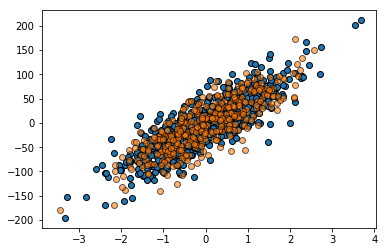

In [17]:
X, y = make_regression(n_samples=1000, n_features=1,
                                      n_informative=1, noise=30)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = y.min() - .5, y.max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

X = StandardScaler().fit_transform(X)
X, X1, y, y1 = train_test_split(X, y, test_size=.4, random_state=42)

# # just plot the dataset first
# figure = plt.figure(figsize=(8, 6))
# cm = plt.cm.RdBu
# cm_bright = ListedColormap(['#FF0000', '#0000FF'])
# #ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

# # Plot the training points
plt.scatter(X[:, 0], y, edgecolors='k')
# # and testing points
plt.scatter(X1[:, 0], y1, alpha=0.6, edgecolors='k')

# simple fit

In [46]:
clf = CLF(objective='RMSE', metric='MAE', learning_rate=0.1, depth=7, random_seed=123)

Built a CatBoost with defiend objective function
{'learning_rate': 0.1, 'depth': 7, 'random_seed': 123}


In [47]:
clf.fit(X, y, num_boost_round=100, verbose=10)

0:	learn: 41.8623143	total: 2.88ms	remaining: 285ms
10:	learn: 27.9475054	total: 29.9ms	remaining: 242ms
20:	learn: 25.1126269	total: 56.2ms	remaining: 211ms
30:	learn: 24.4780111	total: 82.6ms	remaining: 184ms
40:	learn: 24.2994909	total: 105ms	remaining: 151ms
50:	learn: 24.2481856	total: 124ms	remaining: 119ms
60:	learn: 24.1702608	total: 144ms	remaining: 92.2ms
70:	learn: 24.0331465	total: 162ms	remaining: 66.3ms
80:	learn: 23.8105594	total: 182ms	remaining: 42.7ms
90:	learn: 23.6712680	total: 208ms	remaining: 20.6ms


In [48]:
y_pred = clf.predict(X1)

In [49]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y1, y_pred)

953.04843122372574

In [50]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y1, y_pred) 

24.518729684225409

# early stop

In [51]:
clf.fit_eval(X, y, X1, y1, num_boost_round=50, early_stopping=5, print_out=True)

{'iteration': 50, 'score': 24.245125}

In [52]:
y_pred = clf.predict(X1)
mean_absolute_error(y1, y_pred) 

24.245125792245034

# Grid Search

In [53]:
params = {
    'learning_rate': 0.05,
    'depth': 6,  # we should let it be smaller than 2^(max_depth)
    'max_bin': 255,  # Number of bucketed bin for feature values
    'bootstrap_type': "Bernoulli", # Bernoulli, Bayesian
    'subsample': 0.9,  # Subsample ratio of the training instance.
#    'sampling_frequency': "PerTree",  # PerTree, PerTreeLevel
    'colsample_bylevel': 0.9,  # Subsample ratio of columns when constructing each tree.
    'reg_lambda': 0,  # L2 regularization term on weights
#    'scale_pos_weight': 1,
#    'class_weights' :  # for imbalance data
    'calc_feature_importance': False}

In [54]:
clf.set_params_dic(params)

{'learning_rate': 0.05, 'depth': 6, 'random_seed': 123, 'max_bin': 255, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9, 'colsample_bylevel': 0.9, 'reg_lambda': 0, 'calc_feature_importance': False}


In [55]:
clf.make_grid(learning_rate = [0.01, 0.05, 0.1], depth = [5, 6, 7, 8])

{'learning_rate': 0.05, 'depth': 6, 'random_seed': 123, 'max_bin': 255, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9, 'colsample_bylevel': 0.9, 'reg_lambda': 0, 'calc_feature_importance': False}
{'learning_rate': [0.01, 0.05, 0.1], 'depth': [5, 6, 7, 8]}
Number of iteration for Optimization:  12


In [56]:
clf.optimization(X, y, X1, y1, num_boost_round=500, early_stopping=5)

100%|██████████| 12/12 [00:04<00:00,  2.59it/s]


In [57]:
clf.scores()

,learning_rate,depth,iterations,score
0,0.05,5,97,24.165599
0,0.10,6,59,24.202285
0,0.01,7,473,24.230352
0,0.05,6,95,24.253026


In [58]:
clf.set_params_scores(clf.scores(), N=0)

{'learning_rate': 0.1, 'depth': 8, 'random_seed': 123, 'max_bin': 255, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9, 'colsample_bylevel': 0.9, 'reg_lambda': 0, 'calc_feature_importance': False}
{'learning_rate': 0.050000000000000003, 'depth': 5, 'random_seed': 123, 'max_bin': 255, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9, 'colsample_bylevel': 0.9, 'reg_lambda': 0, 'calc_feature_importance': False}


In [59]:
clf.fit(X, y)

In [61]:
y_pred = clf.predict(X1)

mean_absolute_error(y1, y_pred) 

24.165599793051996

# CV 

In [62]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)

In [63]:
clf.fit_cv(X, y, kf, verbose_eval = False, num_boost_round = 1000, early_stopping = 5, print_out=True)

Kfold:  0 Number of iteration:  70  Score:  24.675177
Kfold:  1 Number of iteration:  60  Score:  25.922118
Kfold:  2 Number of iteration:  151  Score:  24.461685


# Bayesin

Ignore UserWarning
{'learning_rate': [0.01, 0.1], 'depth': [4, 10]}
[Real(low=0.01, high=0.1, prior='log-uniform', transform='identity'), Integer(low=4, high=10)]


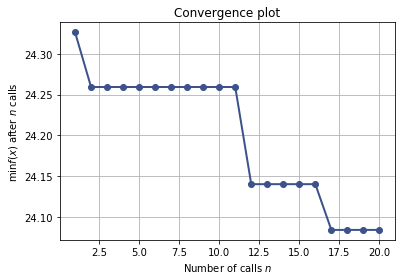

In [64]:
clf.bayesian(X, y, X1, y1, ncalls=20, num_boost_round=100, learning_rate = [0.01, 0.1], depth = [4, 10])

In [65]:
clf.scores()

,learning_rate,depth,score
0,0.088675,10,24.084116
0,0.088556,10,24.084494
0,0.088518,10,24.090604
0,0.051449,10,24.140190
